# <font color="#F48E16">Formación en XAI de Deep Learning: Explicabilidad específica - Redes</font>

Material generado por <a href="https://www.linkedin.com/in/christian-oliva-moya-ingeniero/">Christian Oliva</a>. Cualquier duda, sugerencia o errata, no duden en contactar.

**Versión 1.0** - 29 de agosto de 2025

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import kagglehub
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

## <font color="#F48E16">Datos</font>

En este notebook se muestra la implementación manual de los diferentes algoritmos de explicabilidad genérica vistos durante el curso, que son los siguientes:

- Importancia por permutación

- Relevancia por oclusión

- SHAP

- LIME

Para ello, se van a utilizar diferentes modelos sencillos de SKLearn sobre un dataset de riesgo financiero para la aprobación de préstamos: **Loan Approval Classification Dataset**

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

<hr>

En el notebook se desarrolla el código por completo según una fase sencilla de preprocesamiento de los datos, el entrenamiento de algunos modelos y la explicabilidad utilizando los diferentes algoritmos.

### Descarga de datos de Kaggle

In [2]:
# Download latest version
path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/loan-approval-classification-data


In [3]:
data = pd.read_csv(path + "/loan_data.csv")
data

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [4]:
data["person_age"] = np.log(np.clip(data["person_age"], 0, 70))
data["person_gender"] = data["person_gender"].replace({"female":0, "male":1})
data["person_education"] = data["person_education"].replace({"High School":0, "Associate":1, "Bachelor":2, "Master":3, "Doctorate":4})
data["person_income"] = np.log(data["person_income"])
data["person_emp_exp"] = np.log(data["person_emp_exp"]+1)
data = pd.concat((data, pd.get_dummies(data["person_home_ownership"], prefix="person_home_ownership_")), axis=1)
data = data.drop(columns=["person_home_ownership"])
data["loan_amnt"] = np.log(data["loan_amnt"])
data = pd.concat((data, pd.get_dummies(data["loan_intent"], prefix="loan_intent_")), axis=1)
data = data.drop(columns=["loan_intent"])
data["loan_percent_income"] = np.log(data["loan_percent_income"]+0.1)
data["cb_person_cred_hist_length"] = np.log(data["cb_person_cred_hist_length"])
data["previous_loan_defaults_on_file"] = data["previous_loan_defaults_on_file"].replace({"No": 0, "Yes": 1})

/tmp/ipython-input-2525706371.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["person_gender"] = data["person_gender"].replace({"female":0, "male":1})
/tmp/ipython-input-2525706371.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["person_education"] = data["person_education"].replace({"High School":0, "Associate":1, "Bachelor":2, "Master":3, "Doctorate":4})
/tmp/ipython-input-2525706371.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old 

### Separación en TRAIN-TEST y normalización

In [5]:
X = data.drop(columns=["loan_status"])
y = data["loan_status"]

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
means = X_train_raw.mean()
stds = X_train_raw.std()
X_train = (X_train_raw-means) / stds
X_test = (X_test_raw-means) / stds

In [8]:
X_train.describe()

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,person_home_ownership__MORTGAGE,person_home_ownership__OTHER,person_home_ownership__OWN,person_home_ownership__RENT,loan_intent__DEBTCONSOLIDATION,loan_intent__EDUCATION,loan_intent__HOMEIMPROVEMENT,loan_intent__MEDICAL,loan_intent__PERSONAL,loan_intent__VENTURE
count,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,...,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04
mean,-2.044587e-15,-8.092292e-18,3.088887e-17,-1.318254e-15,-4.144833e-18,-1.299504e-15,1.139681e-15,1.340163e-16,-2.197748e-16,-6.506400e-16,...,-8.990339e-17,1.973730e-19,7.065953e-17,1.028313e-16,6.710681e-17,1.302662e-17,2.171103e-17,5.279727e-18,-2.072416e-17,6.118562e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.634282e+00,-1.106582e+00,-1.288573e+00,-3.820060e+00,-1.480771e+00,-3.838885e+00,-1.867012e+00,-2.348392e+00,-1.469157e+00,-4.827681e+00,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
25%,-6.664523e-01,-1.106582e+00,-1.288573e+00,-6.451277e-01,-7.631502e-01,-5.969609e-01,-8.101133e-01,-8.153795e-01,-7.966108e-01,-6.094639e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
50%,-2.415560e-01,9.036589e-01,-3.606891e-01,-1.742892e-02,1.854926e-01,6.478053e-02,2.628404e-03,-7.049805e-02,-3.194316e-01,1.466317e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
75%,5.180761e-01,9.036589e-01,5.671948e-01,6.186931e-01,7.940326e-01,6.646859e-01,6.782409e-01,7.276121e-01,8.302939e-01,7.435493e-01,...,1.197169e+00,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
max,5.015846e+00,9.036589e-01,2.422962e+00,8.343544e+00,3.526269e+00,2.142782e+00,3.009438e+00,3.394679e+00,3.022695e+00,4.325055e+00,...,1.197169e+00,1.904275e+01,3.759257e+00,9.603814e-01,2.298147e+00,1.969081e+00,2.905366e+00,2.068821e+00,2.229352e+00,2.186582e+00


In [9]:
columnas = X_train_raw.columns
columnas

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'person_home_ownership__MORTGAGE',
       'person_home_ownership__OTHER', 'person_home_ownership__OWN',
       'person_home_ownership__RENT', 'loan_intent__DEBTCONSOLIDATION',
       'loan_intent__EDUCATION', 'loan_intent__HOMEIMPROVEMENT',
       'loan_intent__MEDICAL', 'loan_intent__PERSONAL',
       'loan_intent__VENTURE'],
      dtype='object')

In [10]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [11]:
X_train.shape, y_train.shape

((36000, 21), (36000,))

## <font color="#F48E16">Funciones de Explicabilidad genérica</font>

**OBSERVACION**: He modificado el código para adaptarlo a Keras en lugar de SKLearn. Por ejemplo, llamar a evaluate en lugar de score y cosas así.

In [12]:
def importancia_permutacion(X, y, model, N=10):
    Rx = np.zeros(X.shape[1])
    for i in tqdm(range(X.shape[1])):
        for j in range(N):
            X_perm = X.copy()
            np.random.shuffle(X_perm[:, i])
            Rx[i] += model.evaluate(X_perm, y, batch_size=len(X_perm), verbose=False)[-1]
    Rx = model.evaluate(X, y, batch_size=len(X), verbose=False)[-1] - Rx / N
    return Rx

In [13]:
def relevancia_oclusion(X, y, model, verbose=True):
  if X.ndim == 1: # 1 solo dato, lo ponemos en formato matricial
    X = X[None, :]
    pred = model.predict(X, batch_size=len(X), verbose=False)
  else:
    score = model.evaluate(X, y, batch_size=len(X), verbose=False)[-1]

  num_atributos = X.shape[-1]

  iterador_num_atributos = tqdm(range(num_atributos)) if verbose else range(num_atributos)
  Rx = np.zeros(num_atributos)
  for i in iterador_num_atributos:
    X_null = X.copy()
    X_null[:, i] = 0
    if X.shape[0] == 1: # solo un dato, relevancia local
      Rx[i] = pred[0,y] - model.predict(X_null, batch_size=len(X_null), verbose=False)[0,y]
    else: # más de un dato, relevancia global
      Rx[i] = score - model.evaluate(X_null, y, batch_size=len(X_null), verbose=False)[-1]
  return Rx

In [14]:
def shap(X, y, model, item, N=10, verbose=True):
    num_atributos = X.shape[1]
    shap_values = np.zeros(num_atributos)
    x = X[item][None, :]
    y = y[item]

    baseline = model.predict(X, batch_size=len(X), verbose=False).mean(axis=0, keepdims=True)

    iterador_N = tqdm(range(N)) if verbose else range(N)
    for _ in iterador_N:
      prev_pred = baseline
      perm = np.random.permutation(num_atributos)
      for c, i in enumerate(perm):
        x_S = x.copy()
        x_S[:, perm[c+1:]] = X.mean(axis=0)[perm[c+1:]] # Esta estrategia puede ser diferente
        pred = model.predict(x_S, batch_size=len(x_S), verbose=False)
        shap_values[i] += (pred - prev_pred)[0,y]
        prev_pred = pred

    return shap_values / N

In [15]:
def lime(X, y, model, item, D=1000):
  num_atributos = X.shape[1]
  x0 = X[item][None, :]
  y = y[item]

  # 1. Generamos dataset sintetico X_perturbed alrededor de x0
  X_perturbed = np.repeat(x0, D, axis=0)
  noise = np.random.normal(size=X_perturbed.shape) * X.std(axis=0, keepdims=True)
  X_perturbed += noise

  # 2. Se calculan las predicciones del modelo sobre X_perturbed
  y_perturbed = model.predict(X_perturbed, batch_size=len(X_perturbed), verbose=False)[:, y]

  # 3. Se asignan pesos a los puntos de X_perturbed según la distancia a x0
  distances = np.linalg.norm(X_perturbed - x0, axis=1) + 1e-8
  weights = 1 / distances # más distancia, menor peso. Esta estrategia puede ser diferente

  # 4. Se entrena un modelo lineal con los puntos de X_perturbed
  linear_model = LinearRegression()
  linear_model.fit(X_perturbed, y_perturbed, sample_weight=weights) # NO OLVIDAR sample_weights
  Rx = linear_model.coef_

  return Rx

## <font color="#F48E16">Coeficiente de Explicabilidad-Rendimiento</font>

In [16]:
def epc(X, y, model, Rx, local=False, verbose=False):
  at = Rx.shape[-1]
  m = model.evaluate(X, y, batch_size=len(X), verbose=False)[-1]
  epc_all = []
  iterador_at = tqdm(range(at)) if verbose else range(at)
  if not local: # Si es global
    for i in iterador_at:
        ar = at - i
        factor1 = (at - ar) / at

        umbral = np.sort(Rx[0])[i] # Usamos el mismo umbral para todo el dataset

        # Prueba 1
        X_prueba1 = X.copy()
        X_prueba1[Rx <= umbral] = 0
        mmas = model.evaluate(X_prueba1, y, batch_size=len(X_prueba1), verbose=False)[-1]

        # Prueba 2
        X_prueba2 = X.copy()
        X_prueba2[Rx >= umbral] = 0
        mmenos = model.evaluate(X_prueba2, y, batch_size=len(X_prueba2), verbose=False)[-1]

        factor2 = (mmas - mmenos) / m

        epc = factor1 * factor2
        epc_all.append(epc)

  else: # Si es local
    for i in iterador_at:
        ar = at - i
        factor1 = (at - ar) / at

        # Prueba 1
        X_prueba1 = X.copy()
        for j, (x, r) in enumerate(zip(X, Rx)): # Por cada instancia x hay una relevancia r
            umbral = np.sort(r)[i] # y tenemos que usar esa r para definir el umbral
            X_prueba1[j, r <= umbral] = 0
        mmas = model.evaluate(X_prueba1, y, batch_size=len(X_prueba1), verbose=False)[-1]

        # Prueba 2
        X_prueba2 = X.copy()
        for j, (x, r) in enumerate(zip(X, Rx)): # Lo mismo aquí con la prueba 2
            umbral = np.sort(r)[i]
            X_prueba2[j, r >= umbral] = 0
        mmenos = model.evaluate(X_prueba2, y, batch_size=len(X_prueba2), verbose=False)[-1]

        factor2 = (mmas - mmenos) / m

        epc = factor1 * factor2
        epc_all.append(epc)

  return np.array(epc_all)

## <font color="#F48E16">Explicabilidad específica de las redes neuronales</font>

**IMPORTANTE**: Por simplicidad para los algoritmos más pesados, vamos a utilizar solo un trocito de X_train como si fuese nuestro dataset completo.

In [17]:
X_train_small = X_train[:100]
y_train_small = y_train[:100]

### Caso 1: Red neuronal multicapa

In [18]:
def build_model(input_dims, output_dims, units, optimizer="Adam", l1reg=0.0, activation="relu"):
    input_layer = tf.keras.layers.Input(shape=(input_dims,))
    dense_layer = tf.keras.layers.Dense(units, activation=activation, kernel_regularizer=tf.keras.regularizers.l1(l1reg))(input_layer)
    output_layer = tf.keras.layers.Dense(output_dims, activation="softmax")(dense_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [19]:
units = 10
l1reg = 0.0
learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = build_model(input_dims=X_train.shape[1], output_dims=len(np.unique(y_train)), units=units, optimizer=optimizer, l1reg=l1reg)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242 (968.00 B)

 Trainable params: 242 (968.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8665 - loss: 0.2888 - val_accuracy: 0.9064 - val_loss: 0.2080
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9098 - loss: 0.2008 - val_accuracy: 0.9108 - val_loss: 0.1983
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9130 - loss: 0.1909 - val_accuracy: 0.9140 - val_loss: 0.1919
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9161 - loss: 0.1875 - val_accuracy: 0.9168 - val_loss: 0.1873
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9153 - loss: 0.1859 - val_accuracy: 0.9153 - val_loss: 0.1891


In [21]:
# Esta celda tarda un ratito. No volver a ejecutar en clase. SHAP es muy lento y por eso lo comento!!

Rx_perm_rl = importancia_permutacion(X_train, y_train, model, N=10)
print(" > Permutación DONE")
Rx_oclu_rl = relevancia_oclusion(X_train, y_train, model, verbose=False)
print(" > Oclusión global DONE")
Rx_oclu_local_rl = np.array([relevancia_oclusion(X_train_small[item], y_train_small[item], model, verbose=False) for item in range(len(X_train_small))])
print(" > Oclusión local DONE")
#Rx_shap_rl = np.array([shap(X_train_small, y_train_small, model, item, N=50, verbose=False) for item in range(len(X_train_small))])
#print(" > SHAP DONE")
Rx_lime_rl = np.array([lime(X_train_small, y_train_small, model, item) for item in range(len(X_train_small))])
print(" > LIME DONE")

100%|██████████| 21/21 [00:32<00:00,  1.52s/it]


 > Permutación DONE
 > Oclusión global DONE
 > Oclusión local DONE
 > LIME DONE


In [22]:
epc_perm_rl = epc(X_train, y_train, model, np.repeat(Rx_perm_rl[None, :], X_train.shape[0], axis=0), verbose=True)
epc_oclu_rl = epc(X_train, y_train, model, np.repeat(Rx_oclu_rl[None, :], X_train.shape[0], axis=0), verbose=True)
epc_oclu_local_rl = epc(X_train_small, y_train_small, model, Rx_oclu_local_rl, local=True, verbose=True)
#epc_shap_rl = epc(X_train_small, y_train_small, model, Rx_shap_rl, local=True, verbose=True)
epc_lime_rl = epc(X_train_small, y_train_small, model, (Rx_lime_rl*np.sign(X_train_small)), local=True, verbose=True) # Tenemos que multiplicar aquí por el signo de x

100%|██████████| 21/21 [00:04<00:00,  4.52it/s]


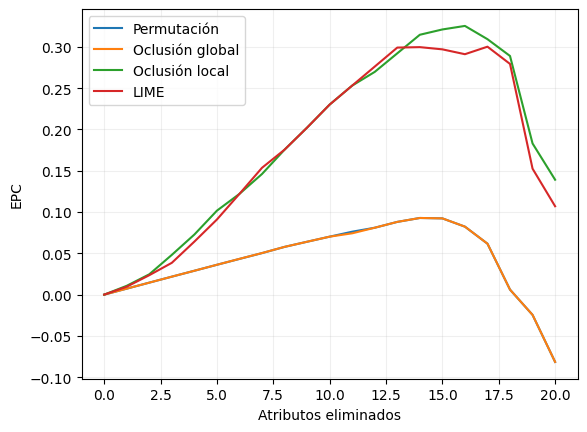

In [23]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.plot(epc_oclu_local_rl, label="Oclusión local")
#plt.plot(epc_shap_rl, label="SHAP")
plt.plot(epc_lime_rl, label="LIME")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

Veamos qué representan realmente los pesos:

In [24]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [25]:
Wh = model.layers[1].weights[0].numpy()
Wy = model.layers[2].weights[0].numpy()

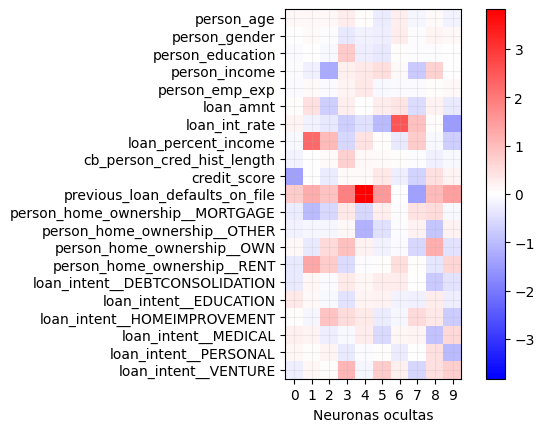

In [26]:
vmax = np.abs(Wh).max()
vmin = -vmax
plt.imshow(Wh, cmap="bwr", vmin=vmin, vmax=vmax)
plt.yticks(range(len(columnas)), columnas)
plt.xticks(range(units))
plt.xlabel("Neuronas ocultas")
plt.colorbar()
plt.grid(alpha=0.2)

#### Suma de pesos en valor absoluto

In [27]:
Rx_weights_global = np.abs(Wh).sum(axis=1, keepdims=True).T
epc_weights_global_rl = epc(X_train, y_train, model, np.repeat(Rx_weights_global, X_train.shape[0], axis=0), verbose=True)

100%|██████████| 21/21 [00:04<00:00,  4.86it/s]


#### Gradient x Input

In [28]:
def gradient(model, X, y):
  X_tf = tf.convert_to_tensor(X, dtype=tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(X_tf)
    y_pred = model(X_tf)

    # Seleccionamos la salida correspondiente a la clase real
    indices = tf.stack([tf.range(tf.shape(y_pred)[0]), y], axis=1)
    y_class = tf.gather_nd(y_pred, indices)

  grads = tape.gradient(y_class, X_tf)
  return grads.numpy()

In [29]:
def gradientxinput(model, X, y):
  return gradient(model, X, y) * X

In [30]:
Rx_gradxinput = gradientxinput(model, X_train_small, y_train_small)
epc_gradxinput_rl = epc(X_train_small, y_train_small, model, Rx_gradxinput, local=True, verbose=True)

100%|██████████| 21/21 [00:04<00:00,  5.01it/s]


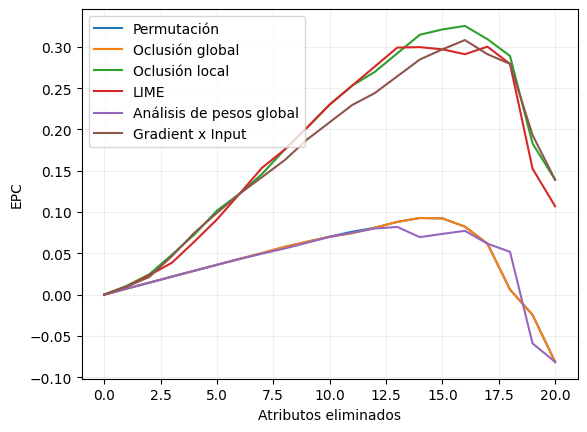

In [31]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.plot(epc_oclu_local_rl, label="Oclusión local")
#plt.plot(epc_shap_rl, label="SHAP")
plt.plot(epc_lime_rl, label="LIME")
plt.plot(epc_weights_global_rl, label="Análisis de pesos global")
plt.plot(epc_gradxinput_rl, label="Gradient x Input")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

### Caso 2: Red neuronal multicapa con Regularización

In [32]:
units = 10
l1reg = 0.1
learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = build_model(input_dims=X_train.shape[1], output_dims=len(np.unique(y_train)), units=units, optimizer=optimizer, l1reg=l1reg)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242 (968.00 B)

 Trainable params: 242 (968.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8355 - loss: 0.7724 - val_accuracy: 0.8757 - val_loss: 0.3747
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8744 - loss: 0.3733 - val_accuracy: 0.8756 - val_loss: 0.3506
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8794 - loss: 0.3562 - val_accuracy: 0.8672 - val_loss: 0.3682
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8797 - loss: 0.3433 - val_accuracy: 0.8850 - val_loss: 0.3420
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8800 - loss: 0.3471 - val_accuracy: 0.8599 - val_loss: 0.3728


In [34]:
# Esta celda tarda un ratito. No volver a ejecutar en clase. SHAP es muy lento y por eso lo comento!!

Rx_perm_rl = importancia_permutacion(X_train, y_train, model, N=10)
print(" > Permutación DONE")
Rx_oclu_rl = relevancia_oclusion(X_train, y_train, model, verbose=False)
print(" > Oclusión global DONE")
Rx_oclu_local_rl = np.array([relevancia_oclusion(X_train_small[item], y_train_small[item], model, verbose=False) for item in range(len(X_train_small))])
print(" > Oclusión local DONE")
#Rx_shap_rl = np.array([shap(X_train_small, y_train_small, model, item, N=50, verbose=False) for item in range(len(X_train_small))])
#print(" > SHAP DONE")
Rx_lime_rl = np.array([lime(X_train_small, y_train_small, model, item) for item in range(len(X_train_small))])
print(" > LIME DONE")

100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


 > Permutación DONE
 > Oclusión global DONE
 > Oclusión local DONE
 > LIME DONE


In [35]:
epc_perm_rl = epc(X_train, y_train, model, np.repeat(Rx_perm_rl[None, :], X_train.shape[0], axis=0), verbose=True)
epc_oclu_rl = epc(X_train, y_train, model, np.repeat(Rx_oclu_rl[None, :], X_train.shape[0], axis=0), verbose=True)
epc_oclu_local_rl = epc(X_train_small, y_train_small, model, Rx_oclu_local_rl, local=True, verbose=True)
#epc_shap_rl = epc(X_train_small, y_train_small, model, Rx_shap_rl, local=True, verbose=True)
epc_lime_rl = epc(X_train_small, y_train_small, model, (Rx_lime_rl*np.sign(X_train_small)), local=True, verbose=True) # Tenemos que multiplicar aquí por el signo de x

100%|██████████| 21/21 [00:04<00:00,  4.44it/s]


In [ ]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.plot(epc_oclu_local_rl, label="Oclusión local")
#plt.plot(epc_shap_rl, label="SHAP")
plt.plot(epc_lime_rl, label="LIME")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

Veamos ahora los pesos:

In [37]:
Wh = model.layers[1].weights[0].numpy()
Wy = model.layers[2].weights[0].numpy()

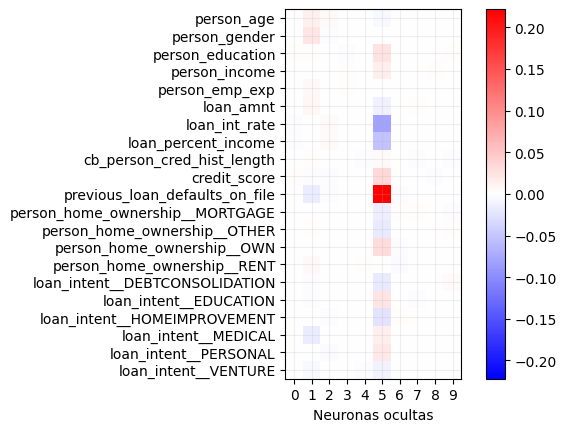

In [38]:
vmax = np.abs(Wh).max()
vmin = -vmax
plt.imshow(Wh, cmap="bwr", vmin=vmin, vmax=vmax)
plt.yticks(range(len(columnas)), columnas)
plt.xticks(range(units))
plt.xlabel("Neuronas ocultas")
plt.colorbar()
plt.grid(alpha=0.2)

In [39]:
Rx_gradxinput = gradientxinput(model, X_train_small, y_train_small)
epc_gradxinput_rl = epc(X_train_small, y_train_small, model, Rx_gradxinput, local=True, verbose=True)

100%|██████████| 21/21 [00:03<00:00,  5.31it/s]


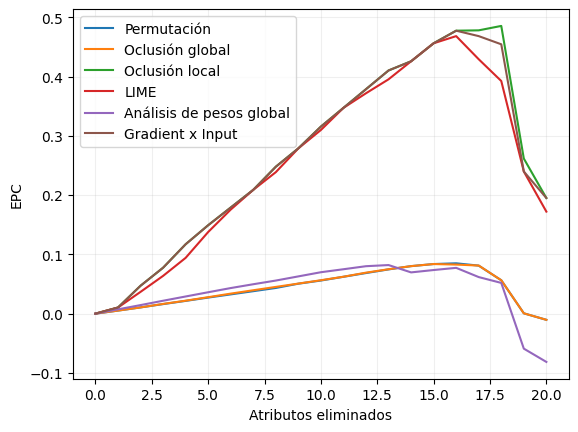

In [40]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.plot(epc_oclu_local_rl, label="Oclusión local")
#plt.plot(epc_shap_rl, label="SHAP")
plt.plot(epc_lime_rl, label="LIME")
plt.plot(epc_weights_global_rl, label="Análisis de pesos global")
plt.plot(epc_gradxinput_rl, label="Gradient x Input")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

En este caso, cuando se aplica regularización L1 a la entrada, **Gradient x Input mejora el rendimiento considerablemente**. Vamos a seguir con esta estrategia con

### Layer-wise Relevance Propagation - Implementación manual y equivalencia con Gradient x Input

In [41]:
def lrp(f):

    @tf.custom_gradient
    def f_custom_grad(x):
        output = f(x)

        def backward(dy):
            custom_grad = f(x)/x
            return dy * custom_grad

        return output, backward
    return f_custom_grad

Vamos a hacerlo primero a mano y luego lo comprobamos con el dataset completo.

In [42]:
N = 1
input_dim = 30
a_dim = 400
h_dim = 300
output_dim = 52

f = tf.nn.sigmoid # SEA LA FUNCION QUE SEA

x = tf.constant(np.random.randn(N, input_dim))
Wxa = tf.Variable(np.random.randn(input_dim, a_dim))
Wah = tf.Variable(np.random.randn(a_dim, h_dim))
Why = tf.Variable(np.random.randn(h_dim, output_dim))

with tf.GradientTape() as tape:
    tape.watch(x)
    za = x @ Wxa # (N, a_dim)
    a = lrp(f)(za)
    zh = a @ Wah # (N, h_dim)
    h = lrp(f)(zh)
    zy = h @ Why # (N, output_dim)
    y = zy
    grad = tape.gradient(y, x)

In [43]:
x = x.numpy()
Wxa = Wxa.numpy()
Wah = Wah.numpy()
Why = Why.numpy()
za = za.numpy()
a = a.numpy()
zh = zh.numpy()
h = h.numpy()
zy = zy.numpy()
y = y.numpy()

In [44]:
Ry = y # (N, output_dim)

# CAPA H
Rh = np.zeros_like(h)
for i in range(h_dim):
    for k in range(output_dim):
        Rh[:, i] += h[:, i] * Why[i,k] * Ry[:, k] / (zy[:, k]+1e-16) # Para evitar division entre 0


# CAPA A
Ra = np.zeros_like(a)
for i in range(a_dim):
    for k in range(h_dim):
        Ra[:, i] += a[:, i] * Wah[i,k] * Rh[:, k] / (zh[:, k]+1e-16) # Para evitar division entre 0


# CAPA X
Rx = np.zeros_like(x)
for i in range(input_dim):
    for k in range(a_dim):
        Rx[:, i] += x[:, i] * Wxa[i,k] * Ra[:, k] / (za[:, k]+1e-16) # Para evitar division entre 0

In [45]:
np.isclose(grad * x, Rx).all()

np.True_

In [46]:
model.save_weights("modelo.weights.h5")

In [47]:
model_lrp = build_model(input_dims=X_train.shape[1], output_dims=len(np.unique(y_train)),
                        units=units, optimizer=optimizer, l1reg=l1reg,
                        activation=lrp(tf.nn.relu)) # Aplicamos la función LRP a relu
model_lrp.load_weights("modelo.weights.h5")

In [48]:
Rx_lrp = gradientxinput(model_lrp, X_train_small, y_train_small) # Aquí usamos model_lrp
epc_lrp_rl = epc(X_train_small, y_train_small, model, Rx_lrp, local=True, verbose=True) # OJO: Aquí usamos model

100%|██████████| 21/21 [00:04<00:00,  4.86it/s]


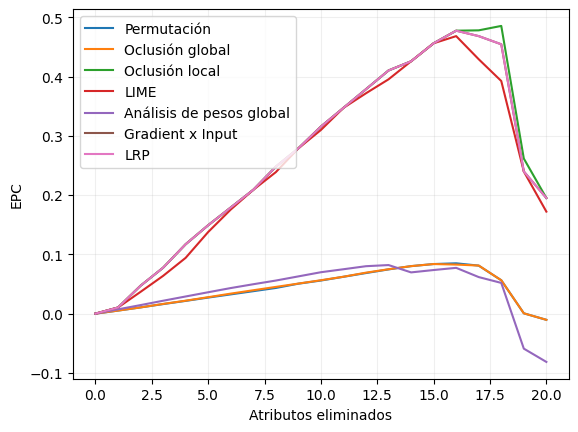

In [49]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.plot(epc_oclu_local_rl, label="Oclusión local")
#plt.plot(epc_shap_rl, label="SHAP")
plt.plot(epc_lime_rl, label="LIME")
plt.plot(epc_weights_global_rl, label="Análisis de pesos global")
plt.plot(epc_gradxinput_rl, label="Gradient x Input")
plt.plot(epc_lrp_rl, label="LRP")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

**¿Por qué salen exactamente iguales Gradient x Input y LRP?**

Vamos a forzar a que no sean iguales

In [50]:
def build_model_lrp(input_dims, output_dims, units, optimizer="Adam", l1reg=0.0, activation=tf.nn.relu):
    input_layer = tf.keras.layers.Input(shape=(input_dims,))
    dense_layer = tf.keras.layers.Dense(units, activation=lrp(activation), kernel_regularizer=tf.keras.regularizers.l1(l1reg))(input_layer)
    output_layer = tf.keras.layers.Dense(output_dims, activation="softmax")(dense_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [51]:
units = 10
l1reg = 0.1
learning_rate = 1e-2

activation = tf.nn.relu # Cambia la función de activación para comprobar

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = build_model(input_dims=X_train.shape[1], output_dims=len(np.unique(y_train)), units=units, optimizer=optimizer, l1reg=l1reg, activation=activation)
model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))
Rx_gradxinput = gradientxinput(model, X_train_small, y_train_small)
model.save_weights("modelo.weights.h5")
model_lrp = build_model_lrp(input_dims=X_train.shape[1], output_dims=len(np.unique(y_train)),
                        units=units, optimizer=optimizer, l1reg=l1reg,
                        activation=activation)
model_lrp.load_weights("modelo.weights.h5")
Rx_lrp = gradientxinput(model_lrp, X_train_small, y_train_small) # Aquí usamos model_lrp
np.isclose(Rx_gradxinput, Rx_lrp).all()

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8156 - loss: 0.7436 - val_accuracy: 0.8830 - val_loss: 0.3445


np.True_